In [1]:
#import library

from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

In [2]:
#data importing

species = pd.read_csv('species_info.csv')
species.info()
species.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",NaN
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered


In [25]:
print('There are {} specieses'.format(species.scientific_name.nunique()))

print('with {} conservation status : {}'.format(species.conservation_status.nunique(),
                                              species.conservation_status.unique()))

There are 5541 specieses
with 5 conservation status : ['No Intervention' 'Species of Concern' 'Endangered' 'Threatened'
 'In Recovery']


In [4]:
#replace nan with more descriptive string

species.fillna('No Intervention', inplace=True)

In [5]:
#counting how much species grouped by conservation status

groupby_scientific_name = species.groupby('conservation_status').scientific_name.count().reset_index()

print(groupby_scientific_name)

  conservation_status  scientific_name
0          Endangered               16
1         In Recovery                4
2     No Intervention             5633
3  Species of Concern              161
4          Threatened               10


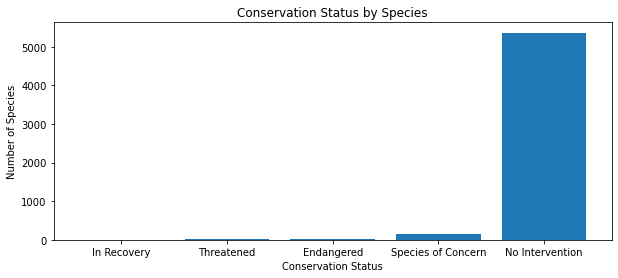

In [6]:
#visualize if conservation status differ from each other


protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

plt.figure(figsize = (10,4))
ax = plt.subplot()
ax.set_xticks(range(len(protection_counts.conservation_status)))
ax.set_xticklabels(list(protection_counts.conservation_status))
plt.bar(range(len(protection_counts.conservation_status)), protection_counts.scientific_name)
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()
plt.close()

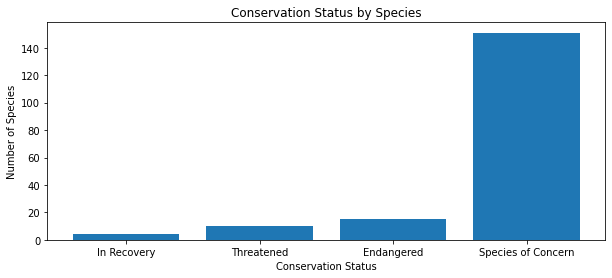

In [7]:
#replot because 'No Intervention' status dominates the plot


protection_counts_stated = protection_counts[protection_counts.conservation_status != 'No Intervention'].reset_index()

plt.figure(figsize = (10,4))
ax = plt.subplot()
ax.set_xticks(range(len(protection_counts_stated.conservation_status)))
ax.set_xticklabels(list(protection_counts_stated.conservation_status))
plt.bar(range(len(protection_counts_stated.conservation_status)), protection_counts_stated.scientific_name)
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()


In [8]:
#checking if certain specieses are more likely to be endangerd


species['is_protected'] = species.apply(lambda row: True if row.conservation_status != 'No Intervention' \
                                        else False, axis=1)

category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()
category_counts.head(100)

,category,is_protected,scientific_name
0,Amphibian,False,72
1,Amphibian,True,7
2,Bird,False,413
3,Bird,True,75
4,Fish,False,115
5,Fish,True,11
6,Mammal,False,146
7,Mammal,True,30
8,Nonvascular Plant,False,328
9,Nonvascular Plant,True,5


In [9]:
#reshape the table to be a more representative table


category_pivot = category_counts.pivot_table(columns='is_protected',\
                                             index='category', \
                                             values='scientific_name').reset_index()


category_pivot.rename(columns={\
                               False: 'not_protected',\
                               True: 'protected'},\
                      inplace=True)

category_pivot['percent_protected'] = 100*(category_pivot.protected / (category_pivot.not_protected + category_pivot.protected))

category_pivot.head(10)

is_protected,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


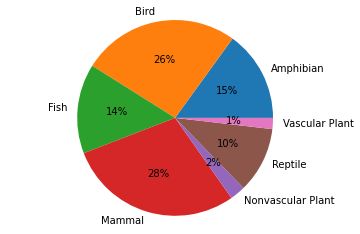

In [23]:
#this plot will be showing the comparison each proportion of endangered specieses from each category


plt.pie(category_pivot.percent_protected, labels = list(category_pivot.category), autopct = '%d%%')
plt.axis('equal')
plt.show()

In [10]:
#significancy test (check if there is significance difference between categories (or just a random chance?))


contingency = []

for i in range(len(category_pivot.category)-1):
    contingency.append([category_pivot.protected.iloc[i], category_pivot.not_protected.iloc[i]])
    
chi2_val, pvalue, dof, _ = chi2_contingency(contingency)

print(chi2_val, ',', pvalue, ',' , dof)

51.51880905236036 , 6.770736859205256e-10 , 5


In [18]:
#the p value appears to be very small, but we don't know which category is more likely to be 
#endangered than the others
#so, we operate chi2 squared to every pairs possible


#chi2 squared

def chi2square(category_index):
    i = category_index
    while i < 6:
        cont = [[category_pivot.protected.iloc[category_index], category_pivot.not_protected.iloc[category_index]],
               [category_pivot.protected.iloc[i], category_pivot.not_protected.iloc[i]]]
        
        _, pvalue, _, _ = chi2_contingency(cont)
        
        i += 1
        
        print('{} and {} is significant with pval {}'.format(category_pivot.category.iloc[category_index], category_pivot.category.iloc[i], pvalue) if pvalue < 0.05 
              else '{} and {} is not significant with pval {}'.format(category_pivot.category.iloc[category_index], category_pivot.category.iloc[i], pvalue))
        

chi2square(0)
print('')
chi2square(1)        
print('')
chi2square(2)
print('')
chi2square(3)
print('')
chi2square(4)
print('')
chi2square(5)

Amphibian and Bird is not significant with pval 1.0
Amphibian and Fish is not significant with pval 0.17593613249594683
Amphibian and Mammal is not significant with pval 0.8247942981524834
Amphibian and Nonvascular Plant is not significant with pval 0.12757669693198975
Amphibian and Reptile is significant with pval 0.001778554820715609
Amphibian and Vascular Plant is not significant with pval 0.7814504686518953

Bird and Fish is not significant with pval 1.0
Bird and Mammal is not significant with pval 0.07668199569057187
Bird and Nonvascular Plant is not significant with pval 0.6875948096661336
Bird and Reptile is significant with pval 1.0546306904975004e-10
Bird and Vascular Plant is not significant with pval 0.05313542232154235

Fish and Mammal is not significant with pval 1.0
Fish and Nonvascular Plant is not significant with pval 0.056148348448900355
Fish and Reptile is significant with pval 0.0004960633228752838
Fish and Vascular Plant is not significant with pval 0.7406524615907

In [27]:
print('''
with comparison of pvalue above we can see that the safest category (at least for now) is reptile,

for amphibian, bird, fish, mammal are basically have similar proportion of endangered specieses out there,

also nonvascular plant is more likely to be endangered than vascular plant''')


with comparison of pvalue above we can see that the safest category (at least for now) is reptile,

for amphibian, bird, fish, mammal are basically have similar proportion of endangered specieses out there,

also nonvascular plant is more likely to be endangered than vascular plant
